## Accessing High Resolution Electricity Access (HREA) data with the Planetary Computer STAC API

The HREA project aims to provide open access to new indicators of electricity access and reliability across the world. Leveraging VIIRS satellite imagery with computational methods, these high-resolution data provide new tools to track progress towards reliable and sustainable energy access across the world.

This notebook provides an example of accessing HREA data using the Planetary Computer STAC API.

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. The Planetary Computer Hub is pre-configured to use your API key.

In [1]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import planetary_computer
import rasterio
import rioxarray

import pystac_client
from rasterio.plot import show

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

The HREA dataset covers all of Africa as well as Ecuador. Let's pick up an area of interest that covers Djibouti and query the Planetary Computer API for data coverage for the year 2019.

In [3]:
area_of_interest = {
    "type": "Point", "coordinates": (42.4841, 11.7101)
}

search = catalog.search(
    collections=["hrea"], intersects=area_of_interest, datetime="2019-12-31"
)

# Check how many items were returned, there could be more pages of results as well
items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 2 Items


We found 3 items for our search. We'll grab jsut the one for Djibouti and see what data assets are available on it.

In [4]:
(item,) = [x for x in items if "Djibouti" in x.id]
data_assets = [
    f"{key}: {asset.title}"
    for key, asset in item.assets.items()
    if "data" in asset.roles
]

print(*data_assets, sep="\n")

lightscore: Probability of electrification
light-composite: Nighttime light annual composite
night-proportion: Proportion of nights a settlement is brighter than uninhabited areas
estimated-brightness: Estimated brightness levels


### Plotting the data

Let's pick the variable `light-composite`, and read in the entire GeoTIFF to plot.

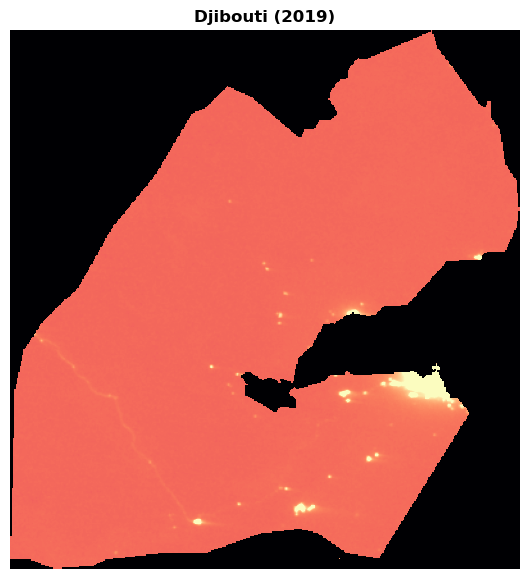

In [5]:
light_comp_asset = item.assets["light-composite"]
data_array = rioxarray.open_rasterio(light_comp_asset.href)

fig, ax = plt.subplots(1, 1, figsize=(14, 7), dpi=100)
show(
    data_array.data,
    ax=ax,
    norm=colors.PowerNorm(1, vmin=0.01, vmax=1.4),
    cmap="magma",
    title="Djibouti (2019)",
)
plt.axis("off")
plt.show()

### Read a window

Cloud Optimized GeoTIFFs (COGs) allows us to effeciently download and read sections of a file, rather than the entire file, when only part of the region is required. The COGs are stored on disk with an internal set of windows. You can read sections of any shape and size, but reading them in the file-defined window size is most efficient. Let's read the same asset, but this time only request the second window. 

Available windows:
((0, 0), Window(col_off=0, row_off=0, width=256, height=256))
((0, 1), Window(col_off=256, row_off=0, width=142, height=256))
((1, 0), Window(col_off=0, row_off=256, width=256, height=165))
((1, 1), Window(col_off=256, row_off=256, width=142, height=165))


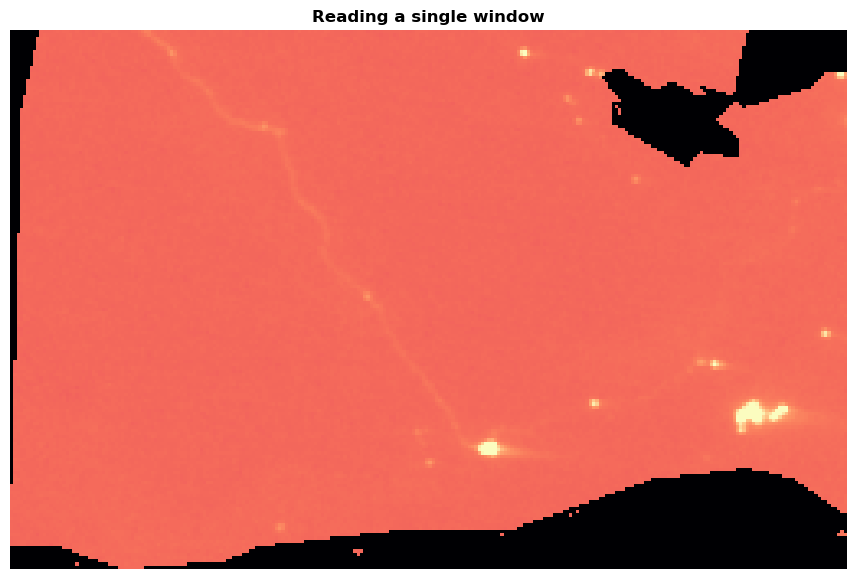

In [6]:
# Reading only the second window of the file, as an example
i_window = 2
with rasterio.open(light_comp_asset.href) as src:
    windows = list(src.block_windows())
    print("Available windows:", *windows, sep="\n")
    _, window = windows[i_window]
    section = data_array.rio.isel_window(window)

fig, xsection = plt.subplots(1, 1, figsize=(14, 7))
show(
    section.data,
    ax=xsection,
    norm=colors.PowerNorm(1, vmin=0.01, vmax=1.4),
    cmap="magma",
    title="Reading a single window",
)
plt.axis("off")
plt.show()

### Zoom in on a region within the retrieved window

Let's plot the region around the city of Dikhil, situated within that second data window, around this bounding box (in x/y coordinates, which is latitude / longitude):

```
(42.345868941491204, 11.079694223371735, 42.40420227530527, 11.138027557181712)
```

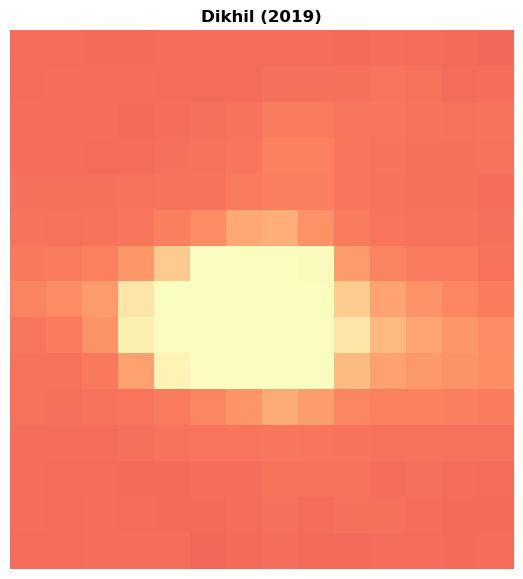

In [7]:
fig, xsection = plt.subplots(1, 1, figsize=(14, 7))
show(
    section.sel(
        x=slice(42.345868941491204, 42.40420227530527),
        y=slice(11.138027557181712, 11.079694223371735),
    ).data,
    ax=xsection,
    norm=colors.PowerNorm(1, vmin=0.01, vmax=1.4),
    cmap="magma",
    title="Dikhil (2019)",
)
plt.axis("off")
plt.show()

### Plot change over time

The HREA dataset goes back several years. Let's search again for the same area, but this time over a longer temporal span.

In [8]:
search = catalog.search(
    collections=["hrea"], intersects=area_of_interest, datetime="2012-12-31/2019-12-31"
)
items = [
    item.to_dict() for item in search.get_items() if "Djibouti" in item.id
]
print(f"Returned {len(items)} Items:")

Returned 8 Items:


We got 8 items this time, each corresponding to single year. To plot the change of light intensity over time, we'll open the same asset on each of these year-items and read in the window with Dikhil. Since we're using multiple items, we'll use `stackstac` to stack them together into a single DataArray for us.

In [9]:
import stackstac

bounds_latlon = (
    42.345868941491204,
    11.079694223371735,
    42.40420227530527,
    11.138027557181712,
)
dikhil = (
    stackstac.stack(items, assets=["light-composite"], bounds_latlon=bounds_latlon)
    .squeeze()
    .compute()
    .quantile(0.9, dim=["y", "x"])
)

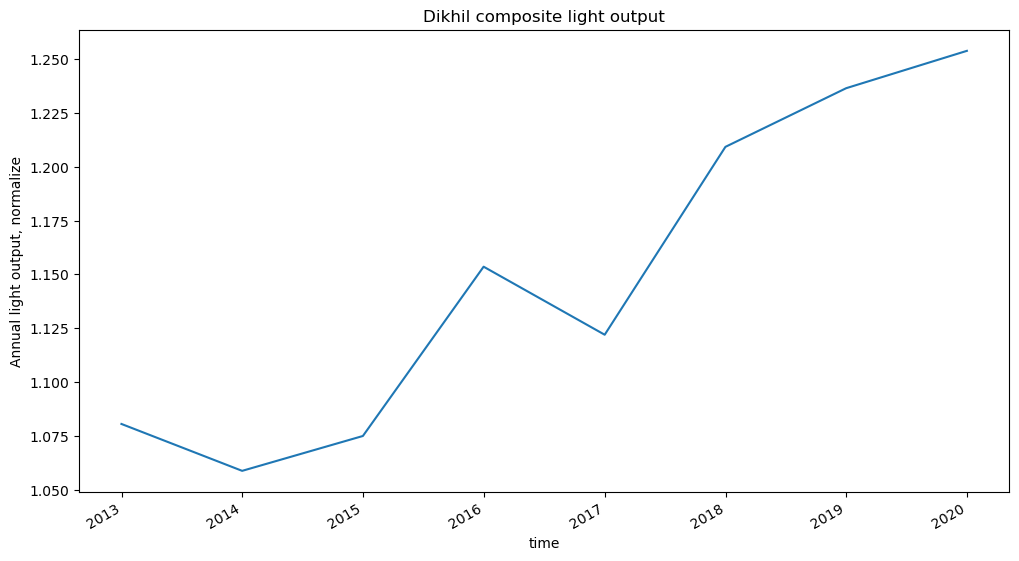

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))

dikhil.plot(ax=ax)

ax.set(title="Dikhil composite light output", ylabel="Annual light output, normalize");